![basira_logo.jpg](../basira_logo.jpg)

# BASIRA LAB CLASSIFICATION TUTORIAL

Oytun Demirbilek, Islem Rekik

In [2]:
import torch

After becoming more familiar of how tensors work, we are ready to train our first model. In this tutorial, we will train an image classifier that detects hand-written digits. Therefore, there will be 10 classes, and we will be using a benchmark dataset MNIST.

# Parameters

In [3]:
BATCH_SIZE = 5
N_EPOCHS = 10
LEARNING_RATE = 1e-3 # this equals to 0.001
WEIGHT_DECAY = 1e-3 # this equals to 0.001

# 1. Prepare Data

In [4]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

In [5]:
mnist_train = MNIST(root="../mnist_tr/", download=True, transform=ToTensor())


To define a validation set, we can use the scikit-learn's train_test_split function that returns us the indices of both subsets, train and validation. Then we can create new datasets with the Subset class, later to pass into dataloader.

In [6]:
# generate indices: instead of the actual data we pass in integers instead
train_indices, val_indices, _, _ = train_test_split(
    range(len(mnist_train)),
    mnist_train.targets,
    test_size=0.1,
)

# generate subset based on indices
tr_dataset = Subset(mnist_train, train_indices)
val_dataset = Subset(mnist_train, val_indices)

tr_dataloader = DataLoader(tr_dataset, batch_size=BATCH_SIZE)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# 2. Model Design

In [7]:
from torch.nn import Module, Sequential, Linear, ReLU, Conv2d, MaxPool2d, AdaptiveMaxPool2d
from torch import Tensor # Only for type-annotations

When designing a model, one of the most important concerns is that you should always keep track of the shape of the tensors at each step, each layer, each operation. When we add the first layer, we should consider the channel size of the image, here we need only one because the MNIST dataset is grayscale. Convolutional layers usually are independent of input size (height and width), but the fully connected layers are not. We can have a __size-independent__ classifier by adding an adaptive layer (AdaptiveMaxPool2d) before the fully connected layers, and we can use our model with varying size of images, or we can add spatial augmentations (i.e., affecting the input image size). This will also be the case when you have the model in production.

In [9]:
class ImageClassifier(Module):
    def __init__(self, n_channels: int = 1) -> None:
        super().__init__()
        self.convs = Sequential(
            Conv2d(n_channels, 6, 5),
            ReLU(),
            MaxPool2d(2, 2),
            Conv2d(6, 16, 5),
            ReLU(),
            AdaptiveMaxPool2d(5),
        )
        self.fcs = Sequential(
            Linear(16 * 5 * 5, 120), 
            ReLU(),
            Linear(120, 84), 
            ReLU(),
            Linear(84, 10),
        )

    def forward(self, x: Tensor) -> Tensor:
        x = self.convs(x)
        x = torch.flatten(x, 1)
        x = self.fcs(x)
        return x

# 3. Training: optimizers and backpropagation

First, lets pick the device we can work with: CPU trainings might take a long time, so we should pick a GPU device.

In [10]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# DEVICE = torch.device("mps" if torch.cuda.is_available() else "cpu") # If on macos

When we define the model, the parameters (weights and biases) are initialized on your CPU. And PyTorch's "Module" class which we inherited from, has a .to() method to shift all parameters to GPU at once. This property is extremely useful, since you dont have to worry about shifting each parameter inside your model to GPU one-by-one.

When we define the optimizer, we should pass the models parameters since it should have access to them to update them based on the attached gradients. You can also play with a few optimizer-related hyperparameters here.

__Note__: PyTorch has 2 different implementations of Adam optimizers: Adam and AdamW. AdamW is weight decay implementation and Adam is L2-regularization implementation. Weight decay implementation is proven to be outperforming, for details you can check: https://arxiv.org/abs/1711.05101

In [39]:
# Define a model:
model = ImageClassifier().to(DEVICE)

# Define loss:
loss_fn = torch.nn.CrossEntropyLoss()

# Define the optimizer, you need to attach your model(s) parameters
# to an optimizer object that will be responsible for updating your model.
optimizer = torch.optim.AdamW(
    model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
)

Training loops in PyTorch has a specific structure. First you need to get the loss, and this loss tensor should have only one value in it to be considered as a __"root node"__ of your gradient tree. Second, at some point before calling the backpropagation, gradients from any previous iteration/operation should be cleaned. Then, you can call .backward() method from the loss tensor which will automatically calculate all gradients at any point on the gradient tree all the way to the model parameters, __"leaf nodes"__ on the gradient tree. Lastly, after the gradients are obtained for the model parameters, optimizer can update the model parameters based on these gradients by calling the .step() method.

SUMMARY: methods should be called in following order:
1. optimizer.zero_grad()
2. tr_loss.backward()
3. optimizer.step()

In [10]:
best_val_loss = 99999999999.0

for epoch in range(N_EPOCHS):
    tr_losses = []
    for input_data, target_data in tr_dataloader:
        # Dont forget to move your tensors to your device of preferrence !
        input_data = input_data.to(DEVICE)
        target_data = target_data.to(DEVICE)
        pred_data = model(input_data)
        tr_loss = loss_fn(pred_data, target_data)

        # First step is to clear the calculated gradients from the previous iteration.
        optimizer.zero_grad()

        # Loss should be 1-value tensor and is a leaf in the gradient tree,
        # Based on the gradient functions attached to the tensors (grad_fn), automatic
        # backpropagation will calculate all gradients in the background.
        tr_loss.backward()

        # Optimizer object is responsible for updating model weights and biases,
        # after the gradients are calculated.
        optimizer.step()

        # tensor.detach() function breaks the gradient tree and returns the tensor only including the data !
        # Thats why you are only allowed to do that after you finish the gradient calculations.
        tr_losses.append(tr_loss.detach())
    
    # tensor.item() returns the one and only attached value here: e.g., tensor((0.00135)) -> 0.00135
    avg_tr_loss = torch.stack(tr_losses).mean().item()

    # After a successful training iteration, we can run a validation loop to monitor model's performance:
    # Since there will be no backpropagation on the validation step, it is unnecessary to store gradients.
    # Therefore we use torch.no_grad to disable all gradient functions during validation for memory efficiency.
    with torch.no_grad():
        val_losses = []
        for input_data, target_data in val_dataloader:
            # Dont forget to move your tensors to your device of preferrence !
            input_data = input_data.to(DEVICE)
            target_data = target_data.to(DEVICE)
            pred_data = model(input_data)
            val_loss = loss_fn(pred_data, target_data)
            val_losses.append(val_loss.detach())
        avg_val_loss = torch.stack(val_losses).mean().item()

    print(f"Epoch: {epoch + 1}/{N_EPOCHS}, Avg.Tr.Loss: {avg_tr_loss}, Avg.Val.Loss: {avg_val_loss}")

    # Save your model if the validation loss is better than before:
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model = model
        torch.save(model.state_dict(), "./digit_classifier.pth")

Epoch: 1/10, Avg.Tr.Loss: 0.15961477160453796, Avg.Val.Loss: 0.07502467930316925
Epoch: 2/10, Avg.Tr.Loss: 0.0638691633939743, Avg.Val.Loss: 0.07010391354560852
Epoch: 3/10, Avg.Tr.Loss: 0.04867938160896301, Avg.Val.Loss: 0.062276579439640045
Epoch: 4/10, Avg.Tr.Loss: 0.04184301197528839, Avg.Val.Loss: 0.06504318118095398
Epoch: 5/10, Avg.Tr.Loss: 0.036380767822265625, Avg.Val.Loss: 0.07948340475559235
Epoch: 6/10, Avg.Tr.Loss: 0.03322033956646919, Avg.Val.Loss: 0.06274998933076859
Epoch: 7/10, Avg.Tr.Loss: 0.029987137764692307, Avg.Val.Loss: 0.07103168964385986
Epoch: 8/10, Avg.Tr.Loss: 0.02925139293074608, Avg.Val.Loss: 0.06753122806549072
Epoch: 9/10, Avg.Tr.Loss: 0.027414770796895027, Avg.Val.Loss: 0.07515975832939148
Epoch: 10/10, Avg.Tr.Loss: 0.02795029617846012, Avg.Val.Loss: 0.08973849564790726


# 4. Testing and evaluation

It is crucial that your testing set is completely disjoint from your training and validation sets, plus it should have the correct representation of the use cases of your model in real life.

In [11]:
# Collect test results one by one (no-batch), because they will be used to calculate metrics.
mnist_test = MNIST(root="../mnist_test/", download=True, train=False, transform=ToTensor())

test_dataloader = DataLoader(mnist_test, batch_size=1)

For testing loop, we also do not need the gradients, and we can store the logits along with the predictions to use them in evaluation. Since logits represent the likelihood of belonging to a class, we can turn them into probabilities by scaling them between 0.0 - 1.0 with the softmax function. Then we can use them in ROC-AUC evaluations.

In [36]:
with torch.no_grad():
    test_preds = []
    test_logits = []
    test_labels = []
    for input_data, target_data in test_dataloader:
        # Dont forget to move your tensors to your device of preferrence !
        input_data = input_data.to(DEVICE)
        target_data = target_data.to(DEVICE)
        pred_data = best_model(input_data).squeeze()
        test_logits.append(torch.softmax(pred_data, 0))
        pred_class = torch.argmax(pred_data)
        test_preds.append(pred_class)
        test_labels.append(target_data)

    logit_preds = torch.stack(test_logits).cpu().numpy()
    class_preds = torch.stack(test_preds).cpu().numpy()
    class_labels = torch.stack(test_labels).cpu().numpy()


In [34]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

Lets take a look at the basic classification metrics: accuracy, f1-score and auc-score:

In [37]:
acc = accuracy_score(class_labels, class_preds)
f1 = f1_score(class_labels, class_preds, average="weighted")
roc_auc = roc_auc_score(class_labels, logit_preds, multi_class="ovr")
acc, f1, roc_auc

(0.9863, 0.9862992478954941, 0.9998414135446936)

Lastly, the multi-class confusion matrix is crucial to see the model behaviour. We can also visualize our results for better interpretation:

[[ 974    0    3    0    0    1    0    1    1    0]
 [   0 1132    2    0    0    0    0    1    0    0]
 [   1    0 1026    1    0    0    0    4    0    0]
 [   0    0    4  999    0    2    0    5    0    0]
 [   0    1    5    0  970    0    0    1    1    4]
 [   2    0    0   10    0  876    1    1    0    2]
 [   8    4    4    0    2    6  933    0    1    0]
 [   1    5    6    1    0    0    0 1010    1    4]
 [   3    0    6    4    1    1    0    2  955    2]
 [   0    3    1    2    7    2    0    3    3  988]]


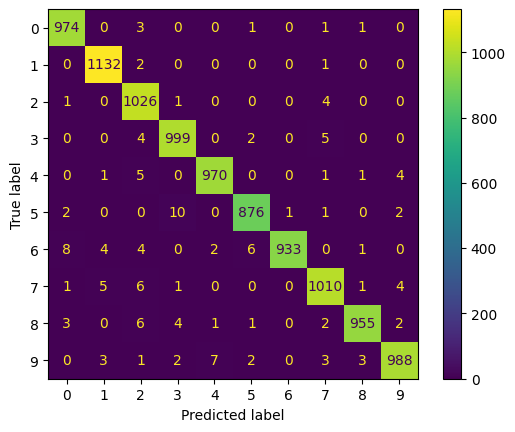

In [38]:
import matplotlib.pyplot as plt

conf_mat = confusion_matrix(class_labels, class_preds)
print(conf_mat)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
disp.plot()
plt.show()

# 5. Model inference

Now use your model in production ! Dont forget to apply the preprocessing steps if you have added any.

In [32]:
from torchvision.io import read_image, ImageReadMode

best_model = ImageClassifier().to(DEVICE)
best_model.load_state_dict(torch.load("./digit_classifier.pth"))
best_model.eval()

with torch.no_grad():
    img = read_image("./sample_draw_3.png", mode=ImageReadMode.GRAY)
    img = img.to(DEVICE).float().unsqueeze(0)
    pred = best_model(img).squeeze()
    pred_class = torch.argmax(pred)
    print(f"Predicted digit in the image: {pred_class}")

Predicted digit in the image: 5


The model is failing to correctly predict the digit. Since it is trained on prepared data with specific characteristics, it fails on different data. This is a very common problem in machine learning that training data domain does not align well with the real-life cases. This concept is widely recognized as __"domain shift"__. Think of possible reasons for that is happening, and possible solutions.

If you plot a sample from MNIST dataset, you will see that the data has fixed size (28, 28) and white drawing on black background, whereas the input image has a different size and is black drawing on white background. We can overcome these problems either by adding __augmentations__ on the training data, but for now lets try to add some quick fix to the test-time and try again:

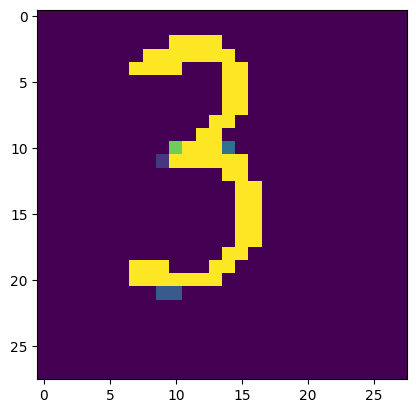

Predicted digit in the image: 3


In [29]:
from torchvision.transforms import Resize

with torch.no_grad():
    resizer = Resize([28, 28])
    img = read_image("./sample_draw_3.png", mode=ImageReadMode.GRAY)
    img = resizer(img)
    plt.imshow(img.squeeze().numpy())
    plt.show()
    img = img.to(DEVICE).float().unsqueeze(0)
    pred = best_model(img).squeeze()
    pred_class = torch.argmax(pred)
    print(f"Predicted digit in the image: {pred_class}")

Of course this will not always be the case that you know why your predictions are not accurate, so you should always try to train models that can generalize better.

Remember you do not always have to do everything from scratch. There are many tools, repositories or Python packages to make machine learning easy. You can also use the template repository here for your future machine learning projects: https://github.com/oytundemirbilek/ml-template-torch

# Additional exercises

1. Add augmentations to enable your model to predict digits accurately even if the input image size is "too different".

2. Pick another loss function and report&compare results.

3. Pick another optimizer and report&compare results.

4. Switch your dataset to the PokemonDataset and try to train an image classifier that detects the type of pokemon from the input image (Type1 column in the table).
